In [1]:
!git clone https://github.com/zae-bayern/elpv-dataset

Cloning into 'elpv-dataset'...
remote: Enumerating objects: 2695, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2695 (delta 2), reused 1 (delta 1), pack-reused 2691
Receiving objects: 100% (2695/2695), 90.79 MiB | 16.82 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (2629/2629), done.


In [2]:
# to see everything that has been downloaded
!ls elpv-dataset/
# no. of images in the dataset
!ls elpv-dataset/images | wc -l
# code in the dataset repo
!ls elpv-dataset/utils

doc  images  labels.csv  LICENSE.md  README.md	utils
2624
elpv_reader.py


In [3]:
# access code
import sys
sys.path.append('elpv-dataset/utils')

In [4]:
# dataset README file said to do this to load the dataset into memory in python
from elpv_reader import load_dataset
elpv_images, elpv_proba, elpv_types = load_dataset()

In [5]:
# dataset matrix ??
elpv_images.shape

(2624, 300, 300)

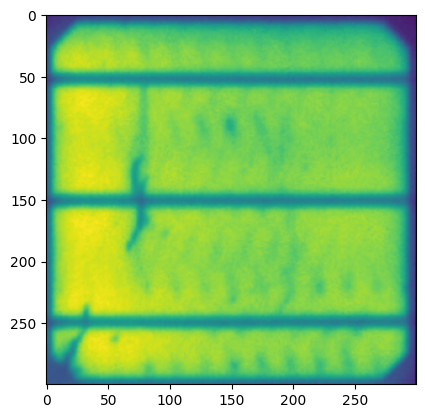

In [6]:
# what is data
import matplotlib.pyplot as plt
plt.imshow(elpv_images [0])

In [7]:
# labels ?
elpv_proba.shape

(2624,)

In [8]:
# label values
set(elpv_proba)

{0.0, 0.3333333333333333, 0.6666666666666666, 1.0}

In [9]:
set(elpv_types)

{'mono', 'poly'}

In [10]:
# pytorch libraries
import torch
import torchvision
import torchvision.transforms as transforms

In [11]:
# pytorch needs to know how to open up images + read labels

import cv2

class PlainDataset(torch.utils.data.Dataset):
  def __init__(self, img_array_list, transform, label_list):
    self.transform = transform
    self.img_array_list = img_array_list
    self.label_list = label_list

  def __len__(self):
    return len(self.img_array_list)

  def __getitem__(self, idx):
    gray = self.img_array_list[idx]
    gray = cv2.resize(gray, dsize = (40,40), interpolation = cv2. INTER_CUBIC)
    gray = gray[4:36, 4:36] # 64 px square
    image = cv2.merge((gray, gray, gray))
    image = self.transform(image)

    label = self.label_list[idx]

    return image, label

In [12]:
import numpy as np

# normalizing images before loading into cnn
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# images to be in update step
batch_size = 4

# split dataset into test and train (2000/624), randomly sampled
shuffle_idx = [ind for ind in range(len(elpv_images))]
np.random.shuffle(shuffle_idx)

# instead of computing a continuous probability of whether a solar cell si defective - network will classify image as 0 (which is good), or 1, 2, 3 with 3 being most defective
trainset = PlainDataset(img_array_list=[elpv_images[j] for j in shuffle_idx[:2000]],
                        transform=transform,
                        label_list=[int(elpv_proba[j]*3) for j in shuffle_idx[:2000]])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = PlainDataset(img_array_list=[elpv_images[j] for j in shuffle_idx[2000:]],
                        transform=transform,
                        label_list=[int(elpv_proba[j]*3) for j in shuffle_idx[2000:]])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [13]:
len(trainset)
len(testset)

624

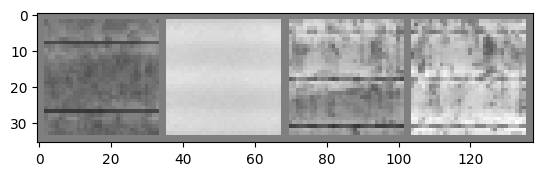

3 0 3 0


In [14]:
# make sure dataloaders are loading images + labels properly
def imshow(img):
  img = img / 2 +0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()


# random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [16]:
# define model - 2 convolutional layers with 18 5x5 kernels in the first layer, 96 5x5 kernels
# 3 linear layers with decreasing numbers of parameters in each - total of 61,266 parameters to learn

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # makes output "image" of the first layer smaller = less compute time
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # new network initialized with 0 - not optima;
        nn.init.kaiming_normal_(self.conv1.weight.data,nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight.data,nonlinearity='relu')

    # tell training functions how to calculate output using the neural network - pytorch library automates calculating the derivative from the loss
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [17]:
import torch.optim as optim

# declaring a new network

net = Net (num_classes = 4)

# show how loss needs to be calculated
criterion = nn.CrossEntropyLoss()

# learning rate - aka how big of a step we take with each new guess
lr = 1e-3
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# try to find a good lr by randomly trying a few
best_loss = 100
best_lr = lr
best_net = net
tries = 0

while tries < 20:
  for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i%100==99:
        if running_loss < best_loss:
          best_net = net
          best_lr = lr
          best_loss = running_loss
          print(f"New best loss with lr {best_lr}")

        print(f'[{epoch+1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
        running_loss = 0.0

  net = Net(num_classes=4)
  lr = np.random.default_rng().uniform(low=1e-5, high=1e-3)
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

  tries += 1
  print(f'*********************** lr = {lr}')

print('Finished Training')

[1,   100] loss: 1.094
[1,   200] loss: 1.003
New best loss with lr 0.001
[1,   300] loss: 0.997
[1,   400] loss: 1.065
New best loss with lr 0.001
[1,   500] loss: 0.967
New best loss with lr 0.001
[2,   100] loss: 0.963
New best loss with lr 0.001
[2,   200] loss: 0.941
[2,   300] loss: 1.040
New best loss with lr 0.001
[2,   400] loss: 0.926
New best loss with lr 0.001
[2,   500] loss: 0.896
*********************** lr = 0.0005513860515544116
[1,   100] loss: 1.253
[1,   200] loss: 1.094
[1,   300] loss: 0.997
[1,   400] loss: 0.974
[1,   500] loss: 1.043
[2,   100] loss: 1.028
[2,   200] loss: 1.067
New best loss with lr 0.0005513860515544116
[2,   300] loss: 0.889
[2,   400] loss: 0.923
[2,   500] loss: 0.953
*********************** lr = 0.00029918645108880775
[1,   100] loss: 1.349
[1,   200] loss: 1.264
[1,   300] loss: 1.157
[1,   400] loss: 1.081
[1,   500] loss: 1.038
[2,   100] loss: 1.103
[2,   200] loss: 0.982
[2,   300] loss: 1.014
[2,   400] loss: 1.009
[2,   500] loss: 1

In [18]:
# helper function to see how network is improving over the course of training

from IPython.display import clear_output
from matplotlib import pyplot as plt

def loss_plot(train_batches, train_loss, test_batches, test_loss,
              figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)

    if len(train_batches) <= 1 or len(test_batches) <= 1:
      return

    plt.scatter(train_batches, train_loss, label='train', color='k')
    m, b = np.polyfit(train_batches, train_loss, 1)
    plt.plot(train_batches, [train_batches * m for train_batches in train_batches] + b)

    plt.scatter(test_batches, test_loss, label='test', color='y')
    m, b = np.polyfit(test_batches, test_loss, 1)
    plt.plot(test_batches, [test_batches * m for test_batches in test_batches] + b)

    plt.title(title)
    plt.grid(True)
    plt.xlabel('mini batches')
    plt.ylabel('loss')
    plt.show();

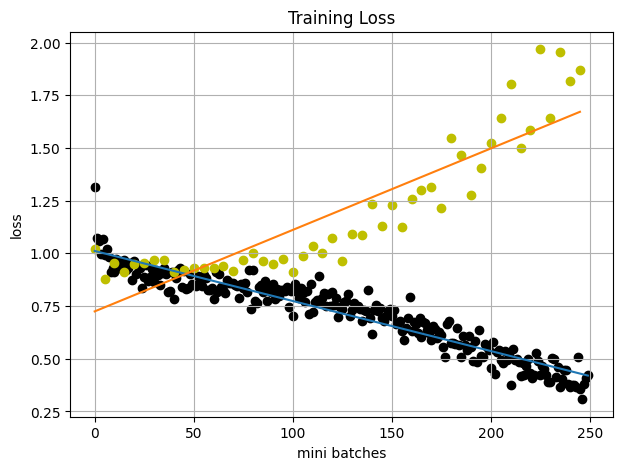

Network began overfitting at epoch 3


In [19]:
# finally training yay
# need to figure out when the network is starting to overfit to training set - so will print the loss on the test set

net = Net(num_classes=4)
optimizer = optim.SGD(net.parameters(), lr=best_lr, momentum=0.9)

import copy

# PyTorch network are pointers so you need to copy the values if you dont want the new variables to be updated
not_overfit_net = copy.deepcopy(net)
early_net = copy.deepcopy(net)
overfit_epoch = -1

loss_trend = []
test_loss_trend = []
for epoch in range(50): # loop over the dataset multiple times

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # get inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()

    if i % 100 == 99: # print every 100 mini-batches
      loss_trend.append(running_loss / 100)
      running_loss = 0.0

      loss_plot(range(len(loss_trend)), loss_trend, [x*5 for x in range(len(test_loss_trend))], test_loss_trend, title = "training loss")

  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        test_loss = criterion(outputs, labels)
    test_loss_trend.append(test_loss)
  loss_plot(range(len(loss_trend)), loss_trend, [x*5 for x in range(len(test_loss_trend))], test_loss_trend, title='Training Loss')

  # if overfitting -> save the last state of the network before it does
  if test_loss_trend[-1] <= loss_trend[-1] and overfit_epoch == -1:
    not_overfit_net = copy.deepcopy(net)
  if epoch == 20:
    early_net = copy.deepcopy(net)

  # if test loss is worse than the training loss -> overfitting
  if test_loss_trend[-1] > loss_trend[-1] and overfit_epoch==-1:
    overfit_epoch = epoch

print(f'Network began overfitting at epoch {overfit_epoch}')


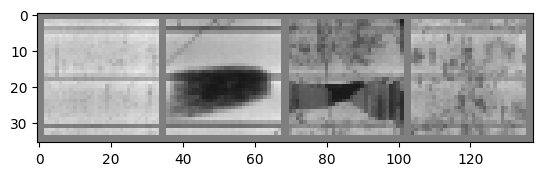

ground truth:  0330


In [20]:
# check - what network classifies on the test set
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print ('ground truth: ', ''.join(f'{labels[j]}'for j in range(4)))

In [21]:
# how well was this done
correct = 0
total = 0
# since there's no training, theres no need to calculate the gradients for outputs
with torch.no_grad():
  for data in trainloader:
    images, labels = data
    # calculate outputs by running images through network
    outputs = net(images)
    # class with highest energy is what is chosen as prediction
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted ==labels).sum().item()

print(f'accuracy on the {len(trainset)} train images: {100 * correct // total} %')

accuracy on the 2000 train images: 86 %


In [38]:


correct = 0
total = 0
# since we're not training = no calculation for gradients for outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = not_overfit_net(images)
        # the class with the highest energy = prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'accuracy on the {len(testset)} test images: {100 * correct // total} %')

accuracy on the 624 test images: 67 %


In [32]:
# where network is failing

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in range(4)}
total_pred = {classname: 0 for classname in range(4)}

# no gradients needed because no training
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(f'{label}')] += 1
            total_pred[int(f'{label}')] += 1



# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    chance = 100 * float(total_pred[classname]) / sum(total_pred.values())
    print(f'Accuracy for class: {classname} is {accuracy:.1f} % (chance is {chance:.1f} %)')
import seaborn as sns
from sklearn import metrics

Accuracy for class: 0 is 69.1 % (chance is 56.1 %)
Accuracy for class: 1 is 40.5 % (chance is 11.9 %)
Accuracy for class: 2 is 8.7 % (chance is 3.7 %)
Accuracy for class: 3 is 61.6 % (chance is 28.4 %)


In [33]:
# to count predictions for each class
correct_pred = {classname: 0 for classname in range(4)}
total_pred = {classname: 0 for classname in range(4)}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = not_overfit_net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(f'{label}')] += 1
            total_pred[int(f'{label}')] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    chance = 100 * float(total_pred[classname]) / sum(total_pred.values())
    print(f'Accuracy for (not-overfit) class: {classname} is {accuracy:.1f} % (chance is {chance:.1f} %)')

Accuracy for (not-overfit) class: 0 is 94.3 % (chance is 56.1 %)
Accuracy for (not-overfit) class: 1 is 0.0 % (chance is 11.9 %)
Accuracy for (not-overfit) class: 2 is 0.0 % (chance is 3.7 %)
Accuracy for (not-overfit) class: 3 is 50.8 % (chance is 28.4 %)
